In [33]:
import os
import pandas as pd
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.pipeline import Pipeline
import copy 
from pandas.plotting import table
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from functools import partial
from sklearn.neural_network import MLPClassifier
import math
import matplotlib.pyplot as plt
import imblearn.ensemble as ensemble
import sklearn.tree as tree
import sklearn.svm as svm
from sklearn.metrics import f1_score,balanced_accuracy_score,recall_score,precision_score,roc_auc_score,matthews_corrcoef

class ClassificationRandomGuess:
    def __init__(self):
        self.y = None

    def fit(self,_,y):
        self.y = y
    
    def predict(self, X):
        return np.random.choice(self.y,size=X.shape[0])
    
class VoteReject:
    def __init__(self):
        pass

    def fit(self,_,__):
        pass
    
    def predict(self, x):
        return np.zeros(x.shape[0])
    
class VoteAccept:
    def __init__(self):
        pass
    
    def fit(self,_,__):
        pass
    
    def predict(self, x):
        return np.ones(x.shape[0])
    
def iclr_x_mapfn(df):
    return df[["num_equations","mean_num_new_symbols_introduced","num_overall_unique_symbols","mean_num_unique_symbols","std_of_unique_symbols","max_representational_complexity"]]

def neurips_x_mapfn(df):
    return df[["num_equations","mean_num_new_symbols_introduced","num_overall_unique_symbols","mean_num_unique_symbols","std_of_unique_symbols","max_representational_complexity"]]

def iclr_y_mapfn(df):

    y = df.status
    y = np.asarray(y)
    y[y == "Reject"] = 0
    y[y == "Desk Reject"] = 0
    y[y == "Top-25%"] = 1
    y[y == "Top-5%"] = 1
    y[y == "Poster"] = 1

    return y.astype(np.int32)

def neurips_y_mapfn(df):
    y = df.status
    y = np.asarray(y)
    y[y == "Reject"] = 0
    y[y == "Poster"] = 1
    y[y == "Spotlight"] = 1
    y[y == "Oral"] = 1

    return y.astype(np.int32)

    
def normalize(train, test):
    mean = np.mean(train,axis=0)
    std = np.std(train,axis=0)

    return (train-mean)/std,(test-mean)/std

def mse(x,y):
    return np.mean((np.asarray(x)-np.asarray(y))**2)

def acc(x,y):
    return np.mean((np.asarray(x) == np.asarray(y)).astype(np.int32))

def split_dataset(df, train_split=0.7,):
    len_dataset = len(df)
    df_deepcopy = copy.deepcopy(df)
    train = df_deepcopy[:int(len_dataset*train_split)]
    test  = df_deepcopy[int(len_dataset*train_split):]
    
    return train,test

def prepare_dataset(df_train,df_test,y_map_fn,X_map_fn,meta_map_fn):

    X_train = X_map_fn(df_train)
    y_train = y_map_fn(df_train)
    meta_train = meta_map_fn(df_train)

    X_test = X_map_fn(df_test)
    y_test = y_map_fn(df_test)
    meta_test = meta_map_fn(df_test)

    return X_train, X_test, y_train, y_test, meta_train, meta_test


def train(models_and_stats, df ,y_map_fn, X_map_fn = lambda df : df[["num_equations","mean_num_new_symbols_introduced","num_overall_unique_symbols","mean_num_unique_symbols","std_of_unique_symbols","max_representational_complexity"]]):

    for _, (model,stats_dict) in models_and_stats.items():
        train,test = split_dataset(df)
        X_train, X_test, y_train, y_test, _ , _ = prepare_dataset(train,test,y_map_fn=y_map_fn,X_map_fn=X_map_fn,meta_map_fn=lambda x : None)
        
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
    
        stats_dict["accuracy"].append(acc(y_test,y_pred))
        stats_dict["f1"].append(f1_score(y_test,y_pred))
        stats_dict["roc_auc_score"].append(roc_auc_score(y_test,y_pred))
        stats_dict["matthews_corrcoef"].append(matthews_corrcoef(y_test,y_pred))

def plot(models_and_stats, global_title):
    sort = lambda d : {key: value for key, value in sorted(d.items(), reverse=True,key=lambda e: np.mean(e[1][1]))}
    subdict = lambda d,subkey : {key : (value[0],value[1][subkey]) for key, value in d.items()}

    accuracy = sort(subdict(models_and_stats,"accuracy"))
    f1 = sort(subdict(models_and_stats,"f1"))
    auc = sort(subdict(models_and_stats,"roc_auc_score"))
    mcc = sort(subdict(models_and_stats,"matthews_corrcoef"))

    fig,axs = plt.subplots(nrows=2,ncols=2)

    def plot(d,ax,title):
        for name,(_,stat) in d.items():
            ax.bar(name,np.mean(stat),color = "blue")
            if len(stat)>1:
                ax.errorbar(name,np.mean(stat),np.std(stat),color = "black")
        ax.set_title(title)
        ax.tick_params(axis='x', labelrotation=75)


    plot(accuracy,axs[0][0],"accuracy")
    plot(f1,axs[0][1],"f1")
    plot(auc,axs[1][0],"roc_auc_score")
    plot(mcc,axs[1][1],"matthews_corrcoef")

    fig.set_size_inches(10,10)
    fig.suptitle(global_title)
    fig.tight_layout()
    fig.savefig("./" + global_title + ".png",)
    plt.show()

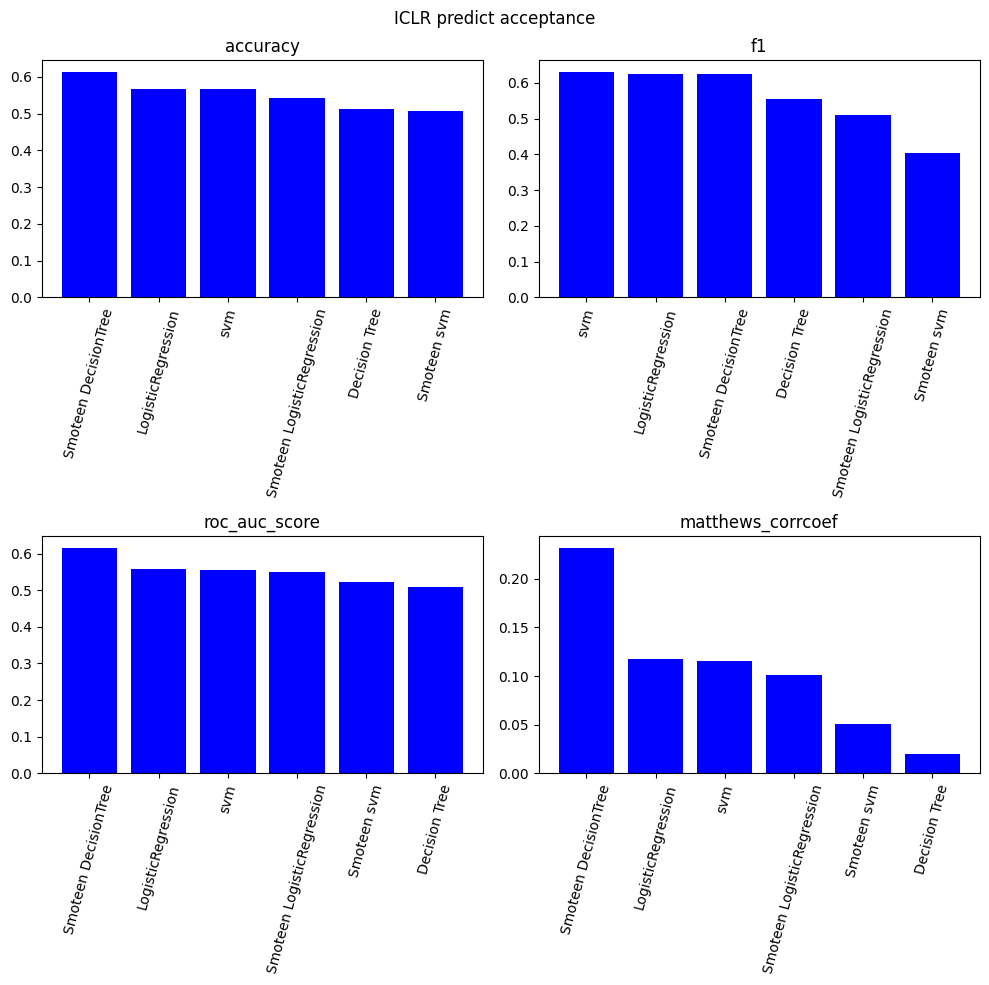

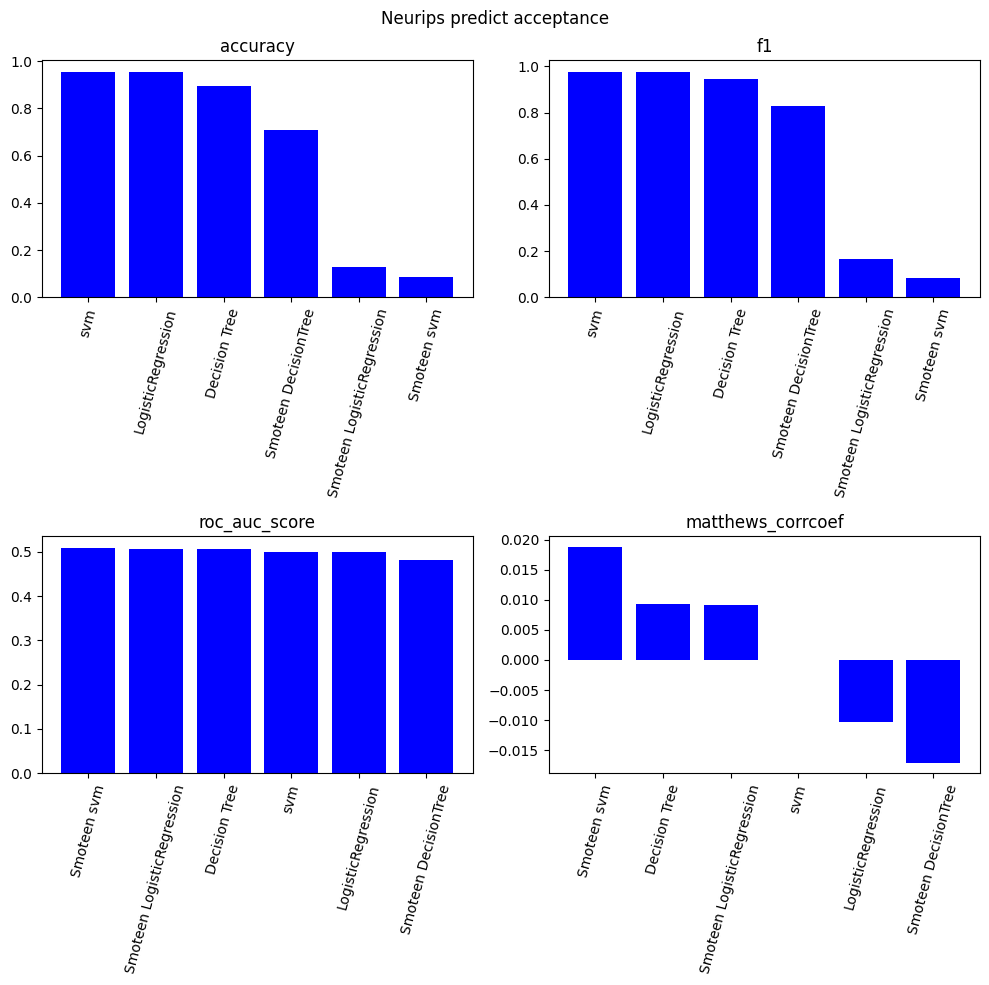

In [35]:

iclr = pd.read_csv("../feature_extraction/iclr.csv",index_col=False)
iclr = iclr[iclr.status != "Desk Reject"]
iclr = iclr[iclr.status != "Withdraw"]
iclr.dropna(axis="index")
iclr.reset_index(drop=True, inplace=True)
neurips = pd.read_csv("../feature_extraction/neurips.csv",index_col=False)
neurips.dropna(axis="index")
neurips.reset_index(drop=True, inplace=True)


models = {"LogisticRegression" : partial(lm.LogisticRegression,max_iter=50000,solver="lbfgs"),
          "Smoteen LogisticRegression" : [("smote", partial(SMOTEENN)),("lg",partial(lm.LogisticRegression,max_iter=50000,solver="lbfgs"))],

          "Decision Tree" : partial(tree.DecisionTreeClassifier),
          "Smoteen DecisionTree" :  [("smote", partial(SMOTEENN)),("dt",partial(tree.DecisionTreeClassifier))],

          "svm" : partial(svm.SVC,kernel="linear"),
          "Smoteen svm" : [("smote", partial(SMOTEENN)),("svm", partial(svm.SVC,kernel="linear"))],

          #"knn" : partial(KNN),
          #"Smoteen knn" : [("smote", partial(SMOTEENN)),("knn", partial(KNN))],

          #"MLP 1" : partial(MLPClassifier,hidden_layer_sizes=(8,),solver='sgd',alpha=0.00001,learning_rate_init=0.0001,batch_size=8,max_iter=1200),
          #"Smoteen MLP 1" : [("smote", partial(SMOTEENN)),("mlp",partial(MLPClassifier,hidden_layer_sizes=(8,),solver='sgd',alpha=0.00001,learning_rate_init=0.0001,batch_size=8,max_iter=1200))],

          #"MLP 2" : partial(MLPClassifier,hidden_layer_sizes=(8,),solver='sgd',alpha=0.001,learning_rate_init=0.0001,batch_size=16,max_iter=1200),
          #"Smoteen MLP 2" : [("smote", partial(SMOTEENN)),("mlp",partial(MLPClassifier,hidden_layer_sizes=(8,),solver='sgd',alpha=0.001,learning_rate_init=0.0001,batch_size=16,max_iter=1200))],
}

models_iclr = {key : (Pipeline([(m[0],m[1]()) for m in model]) if isinstance(model,list) else model(),
                      {"accuracy" : [], "f1" : [], "roc_auc_score" : [], "matthews_corrcoef" : []}) for key,model in models.items()}
models_neurips = {key : (Pipeline([(m[0],m[1]())  for m in model]) if isinstance(model,list) else model(),
                         {"accuracy" : [], "f1" : [], "roc_auc_score" : [], "matthews_corrcoef" : []}) for key,model in models.items()}
for i in range(1):
    train(models_iclr,iclr.sample(frac = 1,random_state=i),y_map_fn=iclr_y_mapfn,X_map_fn=iclr_x_mapfn)
plot(models_iclr,global_title="ICLR predict acceptance")

for i in range(1):
    train(models_neurips,neurips.sample(frac = 1,random_state=i),y_map_fn=neurips_y_mapfn)
plot(models_neurips,global_title="Neurips predict acceptance")



In [36]:


def analysis(df_features,models):
    coefs = models["LogisticRegression"][0].coef_[0]
    df_features["combined_lr"] = df_features.num_equations*coefs[0] + df_features.mean_num_new_symbols_introduced*coefs[1] + df_features.num_overall_unique_symbols*coefs[2]  + df_features.mean_num_unique_symbols*coefs[3]  + df_features.std_of_unique_symbols*coefs[4]  + df_features.max_representational_complexity*coefs[5]

    coefs = models["svm"][0].coef_[0]
    df_features["combined_svm"] = df_features.num_equations*coefs[0] + df_features.mean_num_new_symbols_introduced*coefs[1] + df_features.num_overall_unique_symbols*coefs[2]  + df_features.mean_num_unique_symbols*coefs[3]  + df_features.std_of_unique_symbols*coefs[4]  + df_features.max_representational_complexity*coefs[5]

    coefs = models["Decision Tree"][0].feature_importances_
    df_features["combined_dt"] = df_features.num_equations*coefs[0] + df_features.mean_num_new_symbols_introduced*coefs[1] + df_features.num_overall_unique_symbols*coefs[2]  + df_features.mean_num_unique_symbols*coefs[3]  + df_features.std_of_unique_symbols*coefs[4]  + df_features.max_representational_complexity*coefs[5]

    features = ["model", "num_equations","mean_num_new_symbols_introduced","num_overall_unique_symbols","mean_num_unique_symbols","std_of_unique_symbols","max_representational_complexity"]
    df = pd.DataFrame(columns=features,data=[["Decision Tree", *models["Decision Tree"][0].feature_importances_],
                                            ["LogisticRegression", *models["LogisticRegression"][0].coef_[0]],
                                            ["SVM", *models["svm"][0].coef_[0]],
                                            ["Smoteen Decision Tree", *models["Smoteen DecisionTree"][0][1].feature_importances_],
                                            ["Smoteen LogisticRegression", *models["Smoteen LogisticRegression"][0][1].coef_[0]],
                                            ["Smoteen SVM", *models["Smoteen svm"][0][1].coef_[0]]])
    pd.set_option('display.width', 1000)
    
    print(df)
    print(df_features.corr()["status"].drop("status"))



In [37]:
analysis(iclr_x_mapfn(copy.deepcopy(iclr)).join(pd.DataFrame({"status" : iclr_y_mapfn(copy.deepcopy(iclr))})),models_iclr)

                        model  num_equations  mean_num_new_symbols_introduced  num_overall_unique_symbols  mean_num_unique_symbols  std_of_unique_symbols  max_representational_complexity
0               Decision Tree       0.137202                         0.180048                    0.159130                 0.158033               0.247746                         0.117842
1          LogisticRegression       0.000633                        -0.747522                    0.002762                -0.092127               0.447628                        -0.063209
2                         SVM       0.000621                        -1.737802                    0.008415                -0.240381               0.789354                        -0.096554
3       Smoteen Decision Tree       0.271992                         0.236624                    0.187598                 0.058275               0.075100                         0.170411
4  Smoteen LogisticRegression       0.002340                     

In [38]:
analysis(neurips_x_mapfn(copy.deepcopy(neurips)).join(pd.DataFrame({"status" : neurips_y_mapfn(copy.deepcopy(neurips))})),models_neurips)

                        model  num_equations  mean_num_new_symbols_introduced  num_overall_unique_symbols  mean_num_unique_symbols  std_of_unique_symbols  max_representational_complexity
0               Decision Tree       0.098373                         0.191704                    0.131398                 0.196538               0.303452                         0.078536
1          LogisticRegression       0.000185                        -0.161231                   -0.002807                -0.134672               0.086002                         0.010489
2                         SVM       0.000543                         0.006784                   -0.000360                -0.003389               0.004433                        -0.000080
3       Smoteen Decision Tree       0.446238                         0.169571                    0.123563                 0.037535               0.138340                         0.084754
4  Smoteen LogisticRegression       0.000442                     